In [93]:
import numpy as np
import pickle
from pathlib import Path
import time
import torch
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
%matplotlib inline 
from torchsummary import summary
from torcheval import metrics
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import itertools


In [94]:
if torch.cuda.is_available(): 
 dev = "cuda" 
else: 
 dev = "cpu" 
device = torch.device(dev) 


In [95]:
data_path =  'data/Ferguson_fire_train.npy'
train_data = np.load(data_path)
test_path =  'data/Ferguson_fire_test.npy'
test_data = np.load(test_path)

In [96]:
train_data.shape

(12500, 256, 256)

In [110]:
# Reshape train and test data according to block_size and split_size
split_size = 5
block_size = 100

# Assuming train_data and test_data are numpy arrays or torch tensors
train_4d = train_data.reshape(train_data.shape[0] // block_size, block_size, train_data.shape[1], train_data.shape[1])[:, ::split_size, :, :]
test_4d = test_data.reshape(test_data.shape[0] // block_size, block_size, test_data.shape[1], test_data.shape[1])[:, ::split_size, :, :]

print(train_4d.shape)
print(test_4d.shape)

class ImageDataset(Dataset):
    def __init__(self, data, block_size, transform=None):
        self.data = data
        self.block_size = block_size  # the size of the sequence (t)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x_block = self.data[idx]
        y_block = self.data[idx + 1] if idx + 1 < len(self.data) else self.data[0]  # Handle edge case for the last element
        if self.transform:
            x_block = self.transform(x_block)
            y_block = self.transform(y_block)
        return x_block, y_block

# Create instances of the dataset
train_dataset = ImageDataset(train_4d, block_size)
test_dataset = ImageDataset(test_4d, block_size)

# Define batch size
batch_size = 16

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


(125, 20, 256, 256)
(50, 20, 256, 256)


In [111]:
len(train_dataset.__getitem__(10))
x_block, y_block = train_dataset.__getitem__(10)
print(x_block.shape)
print(y_block.shape)

(20, 256, 256)
(20, 256, 256)


In [105]:
train_4d.shape[0]/batch_size

7.8125

In [112]:
# Retrieve a specific batch from the train_loader
batch_index = 3 # Change this index to select a different batch
train_iter = iter(train_loader)
images = next(itertools.islice(train_iter, batch_index, None))

# Display the length of the images tuple
print("Number of elements in the images tuple:", len(images))  # This should typically print 2

# Display the shape of the input and target sequences
print("Input sequence shape:", images[0].shape)  # Shape of input sequence tensor
print("Target sequence shape:", images[1].shape)  # Shape of target sequence tensor

Number of elements in the images tuple: 2
Input sequence shape: torch.Size([16, 20, 256, 256])
Target sequence shape: torch.Size([16, 20, 256, 256])


In [113]:
# Display the sequence of 10 images
def display_sequence(image_sequence, title):
    sequence_length = image_sequence.shape[0]
    fig, axes = plt.subplots(1, sequence_length, figsize=(sequence_length * 2, 2))
    fig.suptitle(title, fontsize=16)
    
    for i in range(sequence_length):
        ax = axes[i]
        # print(image_sequence.shape)
        # print(image_sequence[0].shape)
        img = image_sequence[i].numpy()  # Permute to (H, W, C) for matplotlib
        ax.imshow(img)
        ax.axis('off')
    
    plt.show()

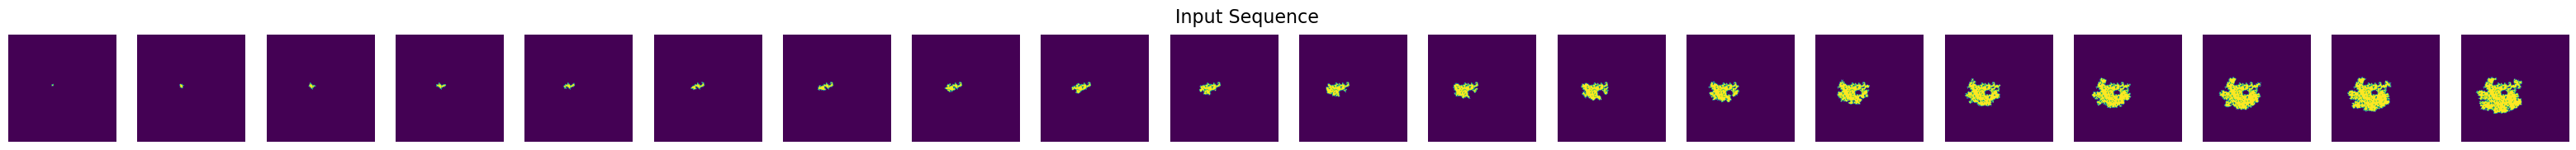

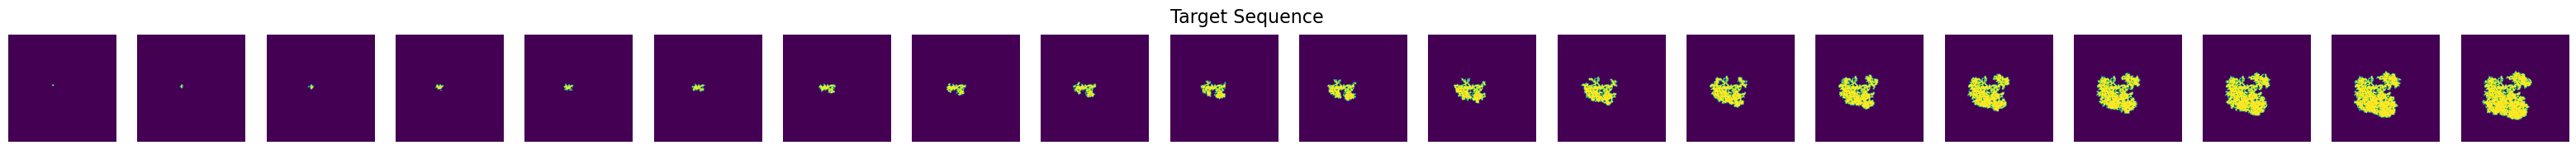

In [114]:
# Display the sequence of images before (x)
display_sequence(images[0][10], title="Input Sequence") # corresponds to x: input sequence
# Display the sequence of images after (y)
display_sequence(images[1][10], title="Target Sequence") # corresponds to y: target sequence

In [84]:
split_size = 5
block_size = 100
train_4d=train_data.reshape(train_data.shape[0]/block_size,block_size,train_data.shape[1],train_data.shape[0])[:,::split_size,:,:]
test_4d = test_data.reshape(test_data.shape[0]/block_size,block_size,test_data.shape[1],test_data.shape[0])[:,::split_size,:,:]

In [87]:
print(train_4d.shape)
print(test_4d.shape)

(125, 20, 256, 256)
(50, 20, 256, 256)


In [13]:
assert (train_shift_4d[0][1].all() ==train_4d[0][2].all())
assert (test_shift_4d[0][1].all() == test_4d[0][2].all())

In [14]:
# del train_data, test_data

In [77]:
trainloader = torch.utils.data.DataLoader(torch.tensor(train_4d,dtype=torch.float32),batch_size=16, shuffle = False)
trainshiftloader = torch.utils.data.DataLoader(torch.tensor(train_4d,dtype=torch.float32),batch_size=16, shuffle = False)
testloader = torch.utils.data.DataLoader(torch.tensor(test_4d,dtype=torch.float32),batch_size=16, shuffle = False)
testshiftloader = torch.utils.data.DataLoader(torch.tensor(test_4d,dtype=torch.float32),batch_size=16, shuffle = False)

In [81]:
batches = next(iter(trainloader))
len(batches)

batches[0].shape

torch.Size([19, 256, 256])

In [79]:
trainloader.dataset.shape

torch.Size([125, 19, 256, 256])

### Code for Training the Model in model_training.ipynb notebook

In [17]:

class VAE(nn.Module):
    def __init__(self, latent_dim = 64, channel_size = block_size):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(3,4,4), stride=(1,2,2), padding=1),  # Example for 3D conv layer
            nn.LeakyReLU(),
            nn.Conv3d(8, 4, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
            nn.LeakyReLU(),
            nn.Conv3d(4,1, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(32*32*channel_size,128),
            nn.LeakyReLU(),
            
        )
        ### Latent space transformations

        self.mu = nn.Linear(128,latent_dim)
        self.logvar = nn.Linear(128,latent_dim)
        
        
        self.decoder = nn.Sequential(
            
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128,32*32*channel_size),
            nn.Unflatten(1,(1,channel_size,32,32)),

            nn.ConvTranspose3d(1,4, kernel_size = (3,4,4), stride= (1,2,2), padding = 1),
            nn.LeakyReLU(),
            nn.ConvTranspose3d(4, 8, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose3d(8, 1, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Calculate standard deviation from log variance
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar

 


In [18]:
def layer_size(W,K = 3,P = 1,S = 1):
    return np.floor((W-K+2*P)/S +1)
def transpose_output_size(input_size, kernel_size = 4, stride=2, padding=1, output_padding=0):
    return (input_size-1)*stride - 2*padding + kernel_size + output_padding
transpose_output_size(64,4,2,1,0)

128

#### Show layers in my model

In [25]:
# split_size = 5

In [27]:
torch.cuda.empty_cache()
# channel_size = 100//split_size -1
model = VAE(latent_dim =8, channel_size = block_size
             ).to(device)
summary(model, (1,block_size,256,256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 8, 10, 128, 128]             392
         LeakyReLU-2      [-1, 8, 10, 128, 128]               0
            Conv3d-3        [-1, 4, 10, 64, 64]           1,540
         LeakyReLU-4        [-1, 4, 10, 64, 64]               0
            Conv3d-5        [-1, 1, 10, 32, 32]             193
         LeakyReLU-6        [-1, 1, 10, 32, 32]               0
           Flatten-7                [-1, 10240]               0
            Linear-8                  [-1, 128]       1,310,848
         LeakyReLU-9                  [-1, 128]               0
           Linear-10                    [-1, 8]           1,032
           Linear-11                    [-1, 8]           1,032
           Linear-12                  [-1, 128]           1,152
        LeakyReLU-13                  [-1, 128]               0
           Linear-14                [-1

In [28]:

# def train(model, optimizer, criterion, data_loader, scheduler = 0):
#     model.train()
#     train_loss = 0
#     for X in data_loader:
#         X = X.to(device).view(-1,1,5,256,256)
#         optimizer.zero_grad()
#         embedding_loss, a2, perplexity = model(X)



#         recon_loss = criterion(a2,X)
#         loss = embedding_loss + recon_loss
#         loss.backward()
#         train_loss += loss*X.size(0)
#         optimizer.step()
#         if scheduler !=0:
#             scheduler.step()

#     return train_loss/len(data_loader.dataset),  recon_loss/len(data_loader.dataset)

###with VQ
def train(model, optimizer, criterion, dataloader, scheduler = 0):
    model.train()
    train_loss = 0
    # for X, Y in zip(dataloader, testloader):
    #     X = X.to(device).view(-1,1,t,256,256) #
    #     Y = Y.to(device).view(-1,1,t,256,256)
    for batch in dataloader:
        input_seq, target_seq = batch[0].to(device), batch[1].to(device)
        input_seq = input_seq.float()
        target_seq = target_seq.float()

        # print("Input seq: ", input_seq.shape)
        # print("Target seq: ", target_seq.shape)

        input_seq = input_seq.unsqueeze(1) # Add dimension
        target_seq = target_seq.unsqueeze(1) # Add dimension

        # print("Input seq reshaped: ", input_seq.shape)
        # print("Target seq reshaped: ", target_seq.shape)
        optimizer.zero_grad()
        a2, mu, logvar =model(input_seq)
        # print("Reconstructed seq: ", a2.shape)
        loss = criterion(target_seq, a2, mu, logvar)
        loss.backward()
        train_loss += loss*input_seq.size(0)
        optimizer.step()
        if scheduler !=0:
            scheduler.step()

    return train_loss/len(dataloader.dataset)
    
def validate(model, criterion, dataloader):
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_seq, target_seq = batch[0].to(device), batch[1].to(device)
            input_seq = input_seq.float()
            target_seq = target_seq.float()
        # for X, Y in zip(dataloader, testloader):
        #     X = X.to(device).view(-1,1,t,256,256)
        #     Y = Y.to(device).view(-1,1,t,256,256)
            a2, mu, logvar =model(input_seq)
            loss = criterion(target_seq, a2, mu, logvar)
            valid_loss += loss*input_seq.size(0)
    return valid_loss/len(dataloader.dataset)

In [29]:
def loss_function(x, x_hat, mu, logvar):
    # Flatten the input and output for binary cross-entropy loss calculation
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3) * x.size(4))
    x_hat = x_hat.view(-1, x_hat.size(1) * x_hat.size(2) * x_hat.size(3) * x_hat.size(4))

    # print("Flattened target seq:", x.shape)
    # print("Flattened reconstructed seq:", x_hat.shape)

    # Binary cross-entropy loss
    mseloss = nn.MSELoss()
    reproduction_loss = mseloss(x_hat, x)#, reduction='mean')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss + KLD

In [30]:
epochs = 20

outputs = []
losses = []
# save_path = "VAE.pth"
# try: 
#     model.load_state_dict(torch.load("VAE.pth",map_location='cpu'))
# except FileNotFoundError:

loss_function = loss_function #torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


liveloss = PlotLosses()
for epoch in range(epochs):
    logs = {}
    loss1 = train(model, optimizer, loss_function, train_loader)
    
    loss2 = validate(model, loss_function, test_loader)
    logs['' + 'log loss'] = loss1.item()
    logs['val_' + 'log loss'] = loss2.item()
    liveloss.update(logs)
    liveloss.draw()
        


KeyboardInterrupt: 

In [ ]:
nums = torch.randn(16,8).to(next(model.parameters()).device)
samples = model.decode(nums).cpu().detach().numpy()


In [ ]:
samples.shape[0]

In [ ]:
fig ,ax = plt.subplots(1,9, figsize = (20,10))
for i in range(9):
        ax[i].imshow(samples[0].reshape(1,channel_size,256,256)[0][i*2])

plt.show()

ValueError: cannot reshape array of size 1245184 into shape (1,99,256,256)

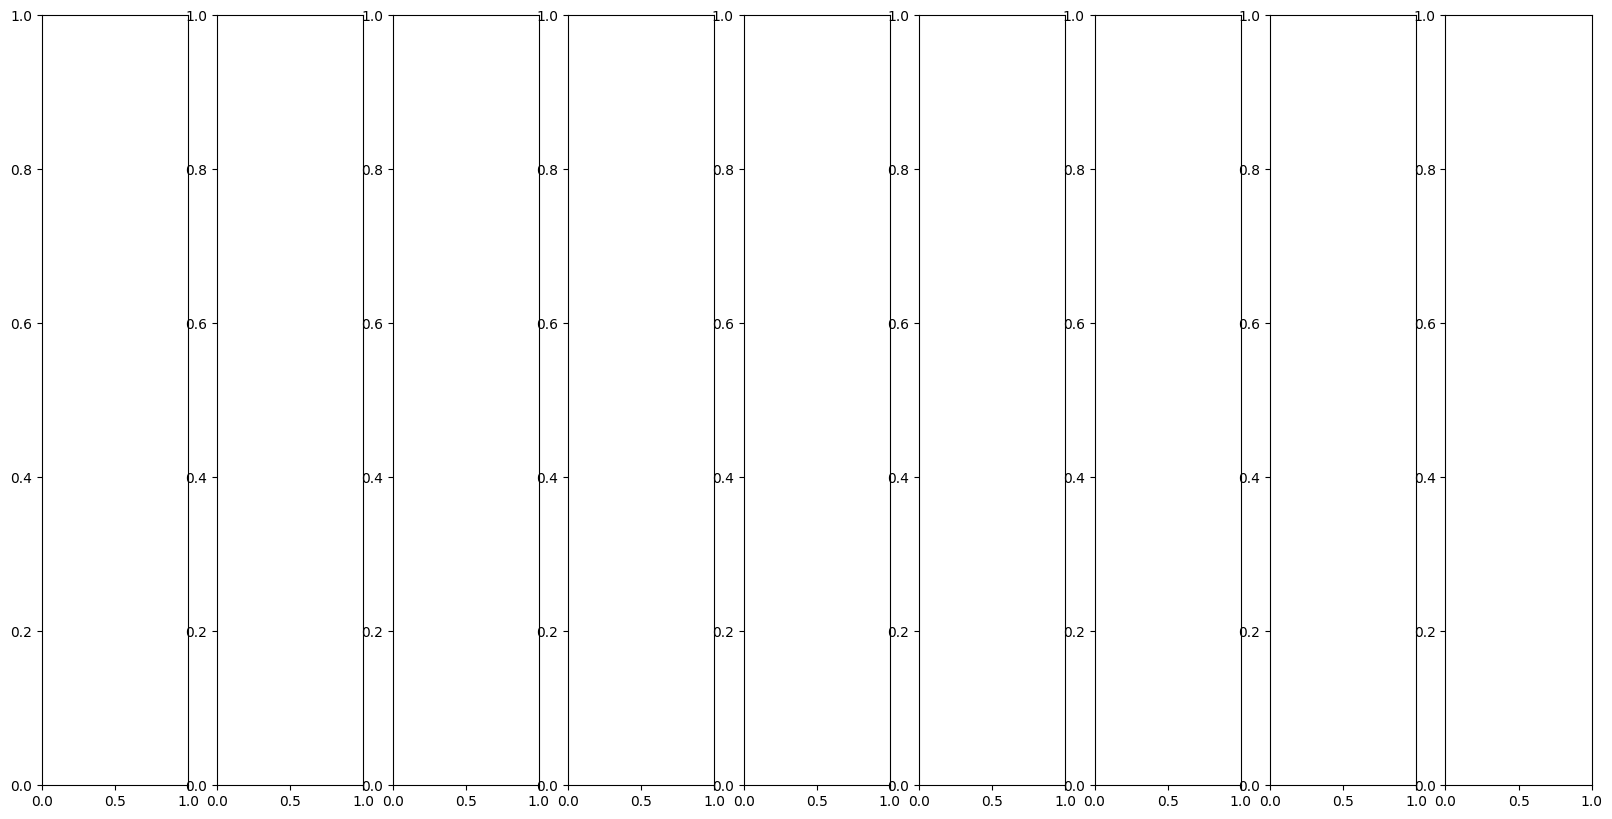

In [ ]:
fig ,ax = plt.subplots(1,9, figsize = (20,10))
for i in range(9):
        ax[i].imshow(train_4d[20].reshape(1,channel_size,256,256)[0][i*10])

plt.show()

In [ ]:
train_4d.shape

(125, 99, 256, 256)

In [ ]:
f = open('results.txt', 'a')
f.write("Task 2 Results\n \n")
f.write('Mean Squared Error: ' + str(mse) + '\n')
f.write('Time taken to transform and revert: ' + str(run_time) + '\n\n')
f.close()